<a href="https://colab.research.google.com/github/Kuriankkr/IEEE-Fradulent-Data/blob/master/Fradulent_Data_Transaction_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reading and importing the necessary libraries required for the project

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
import scipy as sp
from scipy import stats

## Preprocessing, Modelling and Evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Reading the necessary datasets into the folder

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Dataset/IEEE Fradulent/train_identity.csv"
df_id = pd.read_csv(path)

In [0]:
path = "/content/drive/My Drive/Dataset/IEEE Fradulent/train_transaction.csv"
df_tran = pd.read_csv(path)

In [0]:
path = "/content/drive/My Drive/Dataset/IEEE Fradulent/test_identity.csv"
df_test_id = pd.read_csv(path)

In [0]:
path = "/content/drive/My Drive/Dataset/IEEE Fradulent/test_transaction.csv"
df_test_tra = pd.read_csv(path)

##Exploratory Data Analysis

In [0]:
df_tran.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_id.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Let us find the amount of missing data in both the transactions dataframe and the id dataframe

In [0]:
missing_values = df_tran.isnull().sum()
print(missing_values[0:10])
total_cells = np.product(df_tran.shape)
total_missing_values = np.sum(missing_values)
Percentage_missing = ((total_missing_values)/(total_cells))*100
print('Percentage missing in Transaction =',Percentage_missing)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
Percentage missing in Transaction = 41.073431200111266


In [0]:
missing_values = df_id.isnull().sum()
print(missing_values[0:10])
total_cells = np.product(df_id.shape)
total_missing_values = np.sum(missing_values)
Percentage_missing = ((total_missing_values)/(total_cells))*100
print('Percentage missing in ID =',Percentage_missing)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
dtype: int64
Percentage missing in ID = 35.58109650830896


We can see that  there is a good amount of missing data in both of these columns. We shall deal with this later.

##Plotting the amount of transactions and total amount that are fraud and not fraud

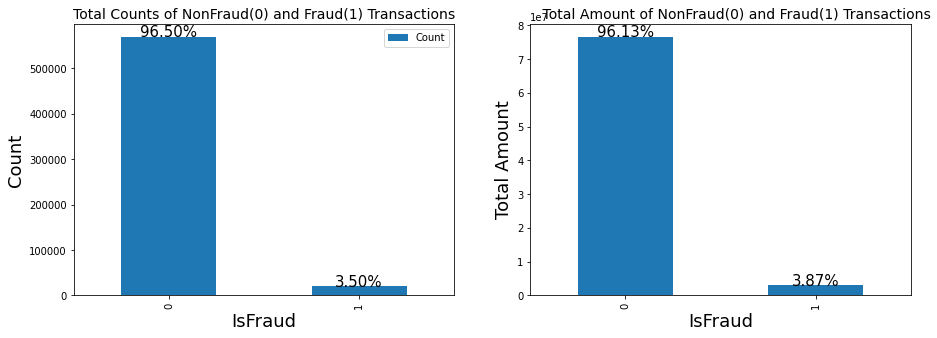

In [0]:
total = len(df_tran)
total_amt = df_tran.groupby(['isFraud'])['TransactionAmt'].sum().sum()

fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (15,5))
df = pd.DataFrame({'Isfraud':df_tran['isFraud'].value_counts().index.tolist(), 'Count':df_tran['isFraud'].value_counts().values})
df.plot.bar(x = 'Isfraud',y = 'Count',ax = ax[0])
ax[0].set_title("Total Counts of NonFraud(0) and Fraud(1) Transactions",fontsize = 14)
ax[0].set_xlabel("IsFraud",fontsize = 18)
ax[0].set_ylabel("Count",fontsize = 18)

for p in ax[0].patches:
   height = p.get_height()
   ax[0].text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

df_tran.groupby(['isFraud'])['TransactionAmt'].sum().plot.bar(label = "Number of Transactions",ax = ax[1])
ax[1].set_title("       Total Amount of NonFraud(0) and Fraud(1) Transactions",fontsize = 14)
ax[1].set_xlabel("IsFraud",fontsize = 18)
ax[1].set_ylabel("Total Amount",fontsize = 18)

for p in ax[1].patches:
   height = p.get_height()
   ax[1].text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=15) 


##Plotting the Total and Individal ECDF distribution
We can see from the graphs that the though the number of transactions are small in the case of Fradulent data the amounts are larger than the case of Non-fradulent data. This is an interesting finding for us to take note

Text(0.5, 0.98, 'Individual ECDF Distribution')

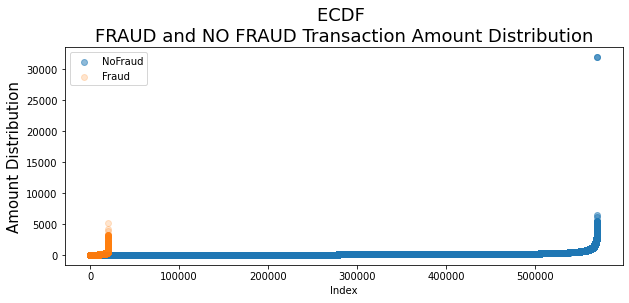

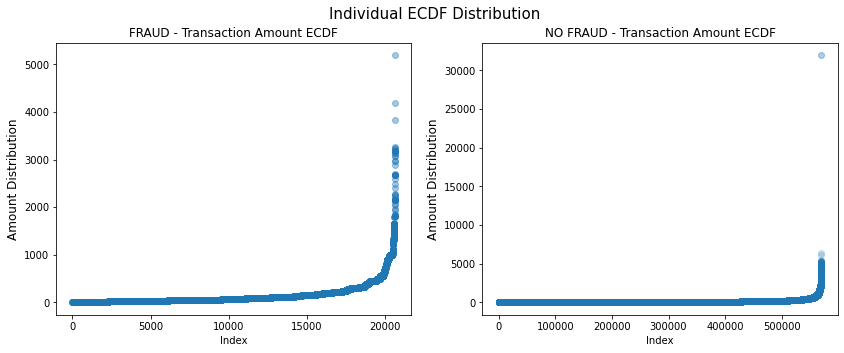

In [0]:
plt.figure(figsize=(10,4))
g1 = plt.scatter(range((df_tran[df_tran['isFraud'] == 0].shape[0])), np.sort(df_tran[df_tran['isFraud'] == 0]['TransactionAmt'].values),label = 'NoFraud',alpha = .5)
g1 = plt.scatter(range(df_tran[df_tran['isFraud'] == 1].shape[0]),np.sort(df_tran[df_tran['isFraud'] == 1]['TransactionAmt'].values), label='Fraud', alpha=.2)
g1= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)
g1 = plt.legend()

fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (14,5))
ax[0].scatter(range(df_tran[df_tran['isFraud'] == 1].shape[0]),np.sort(df_tran[df_tran['isFraud'] == 1]['TransactionAmt'].values), label='isFraud', alpha=.4)
ax[0].set_title("FRAUD - Transaction Amount ECDF", fontsize=12)
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Amount Distribution", fontsize=12)

ax[1].scatter(range(df_tran[df_tran['isFraud'] == 0].shape[0]),
                 np.sort(df_tran[df_tran['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
ax[1].set_title("NO FRAUD - Transaction Amount ECDF", fontsize=12)
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Amount Distribution", fontsize=12)


plt.suptitle('Individual ECDF Distribution', fontsize=15)







## Total quantiles of the Transactions for and Fraud and No Fraud

We can see that the quantiles for 0.5,0.75 and 0.90 have Transaction amounts that are greater in the Fraud section than the No Fraud section. This shows us again confirms the finnding from the above graphs

In [0]:
pd.concat([df_tran[df_tran['isFraud'] == 1]['TransactionAmt']\
.quantile([.01, .1, .25, .5, .75, .9, .99])\
.reset_index(),
df_tran[df_tran['isFraud'] == 0]['TransactionAmt']\
.quantile([.01, .1, .25, .5, .75, .9, .99])\
.reset_index()],axis = 1,keys = ['Fraud','No Fraud'])

Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01        6.74096     0.01        9.51288
1  0.10       18.93600     0.10       26.31000
2  0.25       35.04400     0.25       43.97000
3  0.50       75.00000     0.50       68.50000
4  0.75      161.00000     0.75      120.00000
5  0.90      335.00000     0.90      267.11200
6  0.99      994.00000     0.99     1104.00000

## Total Number of Outliers in the Transactions
This is just to see the number of outliers and remove these rows later while we build our model.

In [0]:
print("Total number of outlier observations: ", sum(stats.zscore(df_tran['TransactionAmt'])>3))
print ("Total number of non-outlier observations:" , sum(stats.zscore(df_tran['TransactionAmt'])<3))
print ("Percentage of outliers in the data:" ,(sum(stats.zscore(df_tran['TransactionAmt'])>3)/len(df_tran))*100)


Total number of outlier observations:  10093
Total number of non-outlier observations: 580447
Percentage of outliers in the data: 1.7091136925525792


# Product Distribution 
We can see that there are 5 Products. Lets take a look at the count and the amount of Fraud and No Fraud data

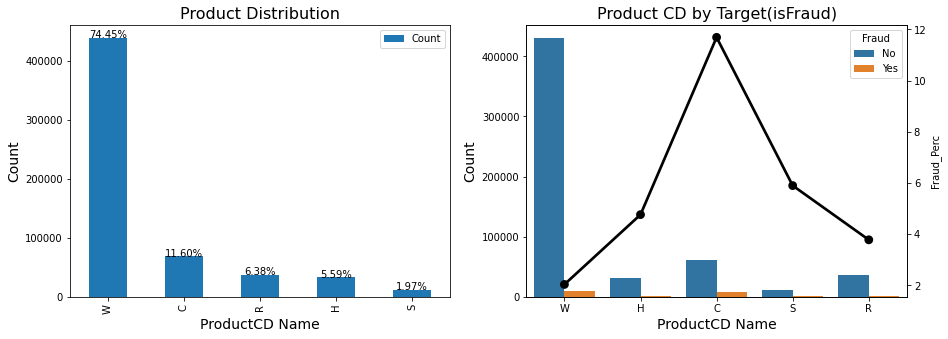

In [0]:
total = len(df_tran['ProductCD'])
#tmp = pd.crosstab(df_tran['ProductCD'], df_tran['isFraud'], normalize='index') * 100 ## Same code shown below 
#tmp = tmp.reset_index() ## Same code shown below
#tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True) ## Same code shown below

df_c = df_tran.groupby(['ProductCD','isFraud'])['isFraud'].size()
df_c = df_c.unstack(level=1).rename_axis(None, axis=1).reset_index()
df_c.columns = ['ProductCD','NoFraud','Fraud']
df_c['Fraud_Perc'] = (df_c['Fraud']/df_c.sum(axis=1))*100


fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (15,5))
df = pd.DataFrame({'Product':df_tran['ProductCD'].value_counts().index.tolist(), 'Count':df_tran['ProductCD'].value_counts().values})
df.plot.bar(x = 'Product',y = 'Count',ax = ax[0])
ax[0].set_title("Product Distribution",fontsize = 16)
ax[0].set_xlabel("ProductCD Name",fontsize = 14)
ax[0].set_ylabel("Count",fontsize = 14)

for p in ax[0].patches:
   height = p.get_height()
   ax[0].text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
 
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_tran)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
g1.set_title("Product CD by Target(isFraud)", fontsize=16)
g1.set_xlabel("ProductCD Name", fontsize=14)
g1.set_ylabel("Count", fontsize=14)
gt = g1.twinx()
gt = sns.pointplot('ProductCD','Fraud_Perc',data = df_c,order=['W', 'H',"C", "S", "R"], legend=False,color='black')





Text(0, 0.5, 'Transaction Values')

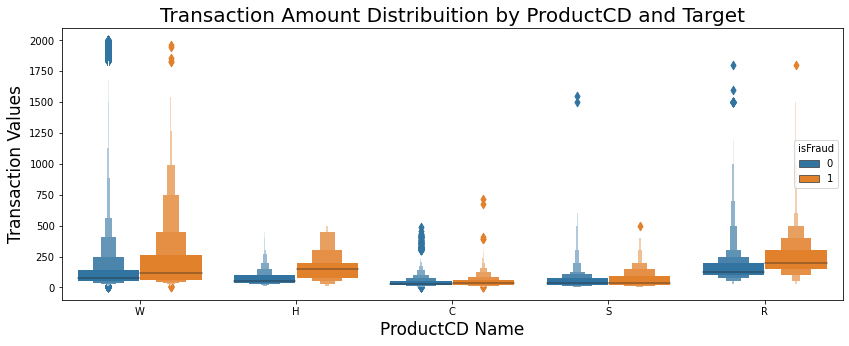

In [0]:
plt.figure(figsize=(14,5))
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
             data=df_tran[df_tran['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)


Therefore we can see here that product W has highest amount of purchase.

Next we can see that the product C has the highest amount percentage of Fraud items when compared to the non fraud amounts

Among the transaction amount produuct W,H and R have the higher amount of fraud transaction items

##Card Features

In [0]:
df_tran[['card1','card2','card3','card5']].describe()

,card1,card2,card3,card5
count,590540.000000,581607.000000,588975.000000,586281.000000
mean,9898.734658,362.555488,153.194925,199.278897
std,4901.170153,157.793246,11.336444,41.244453
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,214.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


In [0]:
df_tran['card4'].unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [0]:
df_tran['card6'].unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

We can learn from that card1,card2,card3 & card5 are continous variables.

Card4 and Card6 are categorical variables

###Card1, Card2,Card3 & Card5 Distribution

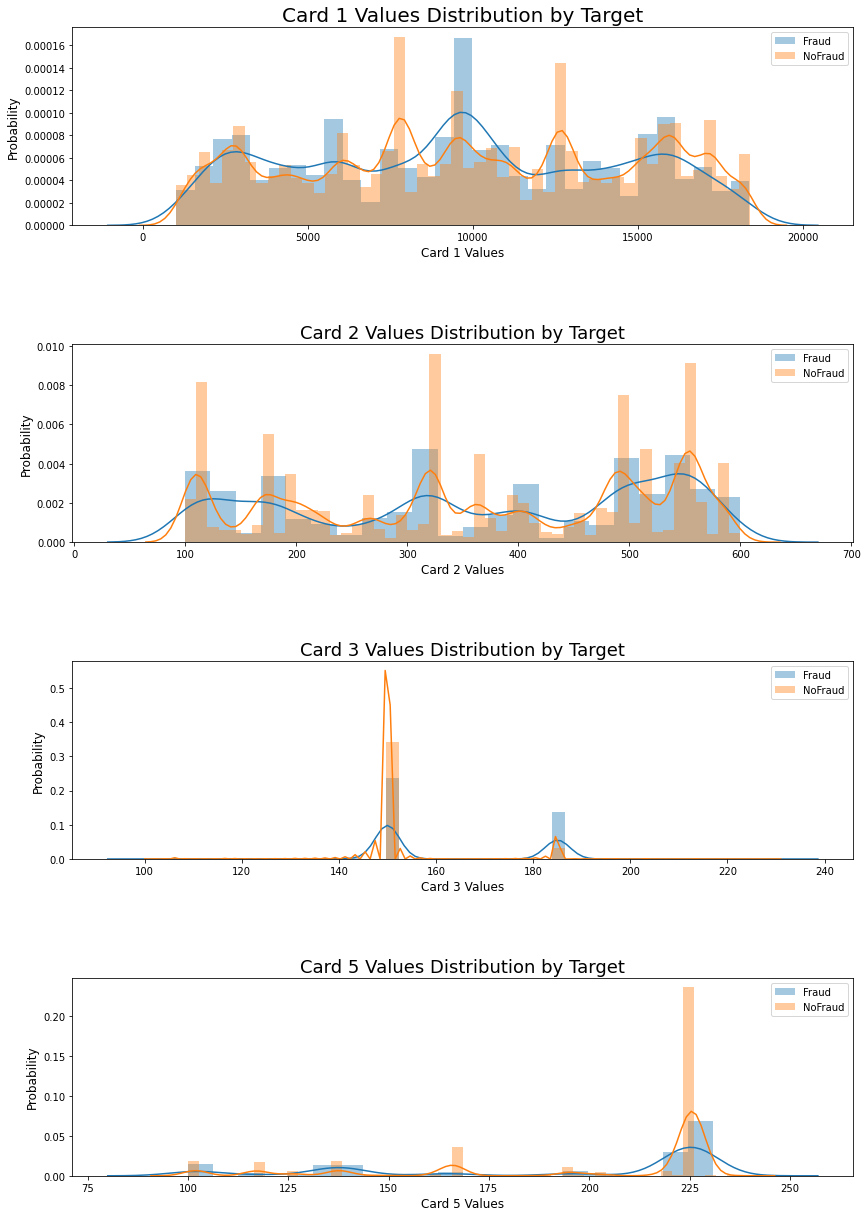

In [0]:
plt.figure(figsize=(14,22))
plt.subplot(411)
g = sns.distplot(df_tran[df_tran['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_tran[df_tran['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=12)
g.set_ylabel("Probability", fontsize=12)

plt.subplot(412)
g1 = sns.distplot(df_tran[df_tran['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_tran[df_tran['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=12)
g1.set_ylabel("Probability", fontsize=12)

plt.subplot(413)
g2 = sns.distplot(df_tran[df_tran['isFraud'] == 1]['card3'].dropna(), label='Fraud')
g2 = sns.distplot(df_tran[df_tran['isFraud'] == 0]['card3'].dropna(), label='NoFraud')
g2.legend()
g2.set_title("Card 3 Values Distribution by Target", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=12)
g2.set_ylabel("Probability", fontsize=12)

plt.subplot(414)
g3 = sns.distplot(df_tran[df_tran['isFraud'] == 1]['card5'].dropna(), label='Fraud')
g3 = sns.distplot(df_tran[df_tran['isFraud'] == 0]['card5'].dropna(), label='NoFraud')
g3.legend()
g3.set_title("Card 5 Values Distribution by Target", fontsize=20)
g3.set_xlabel("Card 5 Values", fontsize=12)
g3.set_ylabel("Probability", fontsize=12)

plt.subplots_adjust(hspace = 0.6, top = 0.85)


We learn from the above plots that Card3 and Card5 have huge spikes at 150 and 225 respectively. This is something interesting that we can notice

###Card 4 Distribution

<Figure size 432x288 with 0 Axes>

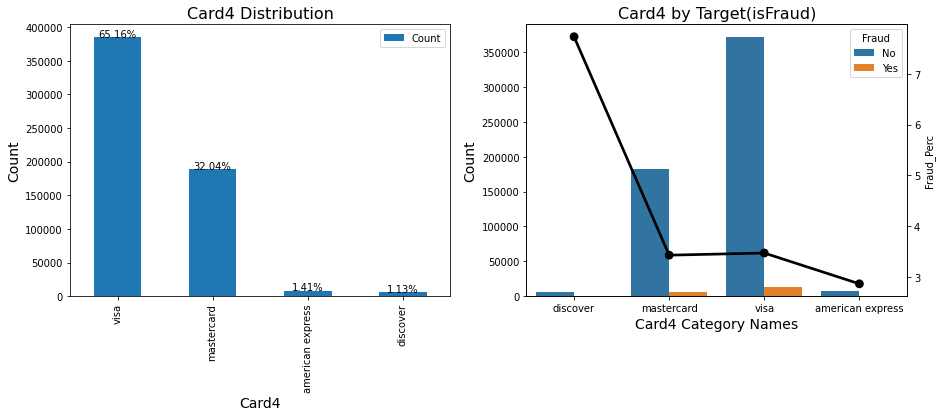

In [0]:
df_c = df_tran.groupby(['card4','isFraud'])['isFraud'].size()
df_c = df_c.unstack(level=1).rename_axis(None, axis=1).reset_index()
df_c.columns = ['card4','NoFraud','Fraud']
df_c['Fraud_Perc'] = (df_c['Fraud']/df_c.sum(axis=1))*100

total = len(df_tran['card4'])
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (15,5))
df = pd.DataFrame({'card4':df_tran['card4'].value_counts().index.tolist(), 'Count':df_tran['card4'].value_counts().values})
df.plot.bar(x = 'card4',y = 'Count',ax = ax[0])
ax[0].set_title("Card4 Distribution",fontsize = 16)
ax[0].set_xlabel("Card4",fontsize = 14)
ax[0].set_ylabel("Count",fontsize = 14)

for p in ax[0].patches:
   height = p.get_height()
   ax[0].text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
   
g1 = sns.countplot(x='card4', hue='isFraud', data=df_tran)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
g1.set_title("Card4 by Target(isFraud)", fontsize=16)
g1.set_xlabel("Card4 Category Names", fontsize=14)
g1.set_ylabel("Count", fontsize=14)
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud_Perc', data=df_c, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])




We can see that the majority of the transaction are in the visa and mastercard. 

Also we can see that the majority of the fraud has taken place in the case of discover (11%), though discover cards have a very small percentage(1.13%) of the total transaction

###Card 6 Distribution

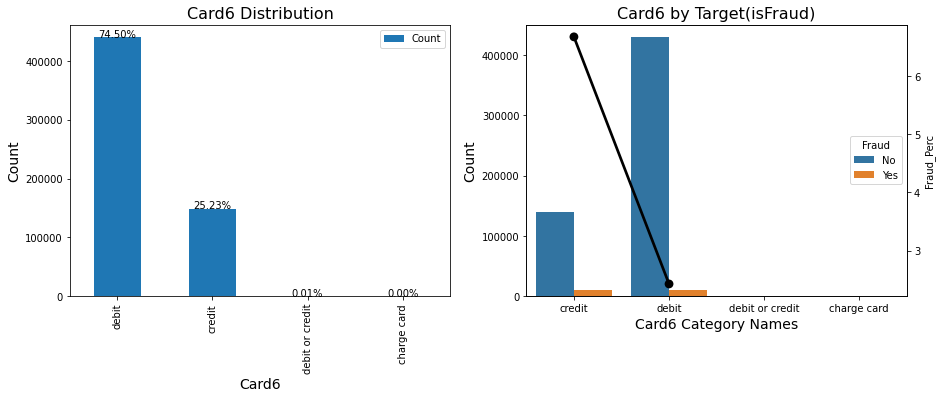

In [0]:
total = len(df_tran['card6'])
df_c = df_tran.groupby(['card6','isFraud'])['isFraud'].size()
df_c = df_c.unstack(level=1).rename_axis(None, axis=1).reset_index()
df_c.columns = ['card6','NoFraud','Fraud']
df_c['Fraud_Perc'] = (df_c['Fraud']/df_c.sum(axis=1))*100




fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (15,5))
df = pd.DataFrame({'card6':df_tran['card6'].value_counts().index.tolist(), 'Count':df_tran['card6'].value_counts().values})
df.plot.bar(x = 'card6',y = 'Count',ax = ax[0])
ax[0].set_title("Card6 Distribution",fontsize = 16)
ax[0].set_xlabel("Card6",fontsize = 14)
ax[0].set_ylabel("Count",fontsize = 14)

for p in ax[0].patches:
   height = p.get_height()
   ax[0].text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

g1 = sns.countplot(x='card6', hue='isFraud', data=df_tran)
plt.legend(title='Fraud', loc='right', labels=['No', 'Yes'])
g1.set_title("Card6 by Target(isFraud)", fontsize=16)
g1.set_xlabel("Card6 Category Names", fontsize=14)
g1.set_ylabel("Count", fontsize=14)
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud_Perc', data=df_c, 
                   color='black', legend=False, 
                   order=['credit','debit','debit or credit','charge card'])  



Note: Here Card6 has debit and credit has almost all of the total transactions.

As for the fraud, Card 6 has the highest amount fraud credit(7%) and debit has around 2.5%. It should be noted that the reason debit or credit or change card doesnt have values is because they are missing data (Nan)

#M1-M9 Features.

Let us see what these featuers and what sort of data and insights we can get from this

In [0]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_tran[col] = df_tran[col].fillna("Miss")

def plotting_dist(df,col):
  tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
  tmp = tmp.reset_index()
  tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

  total = len(df[col])

  plt.figure(figsize=(8,5))
  g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
  g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
  g.set_ylim(0,400000)

  for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 10000,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 
      
  gt = g.twinx()
  gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
  gt.set_ylim(0,20)
  gt.set_ylabel("% of Fraud Transactions", fontsize=16)
  g.set_xlabel(f"{col} Category Names", fontsize=16)
  g.set_ylabel("Count", fontsize=17)

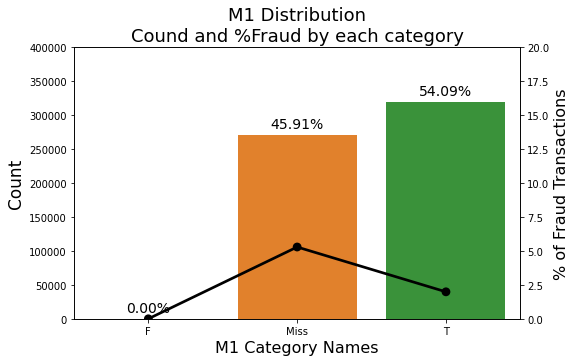

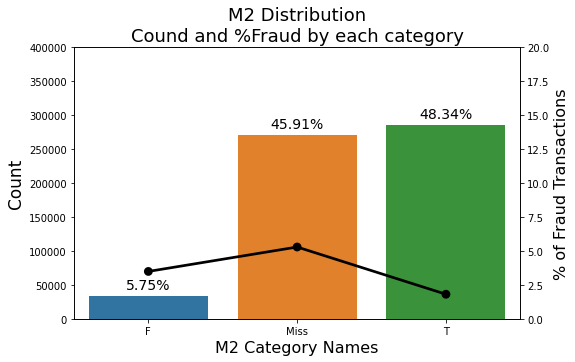

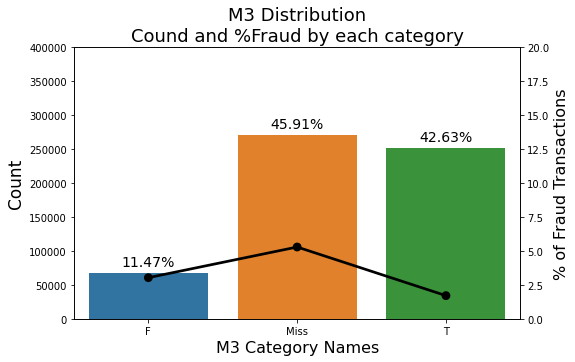

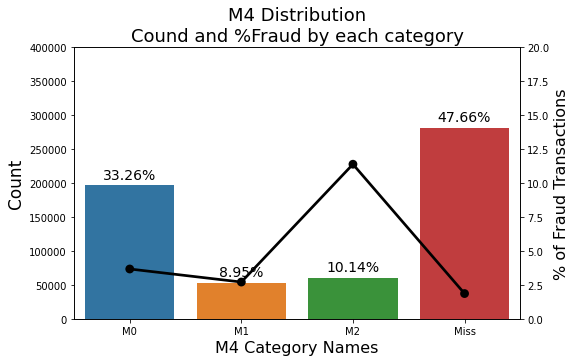

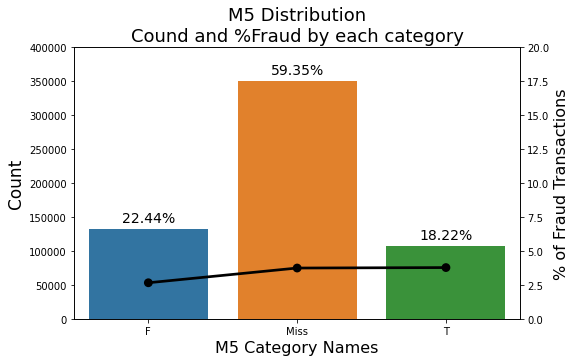

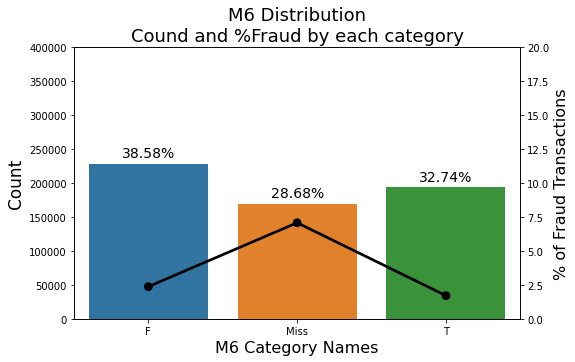

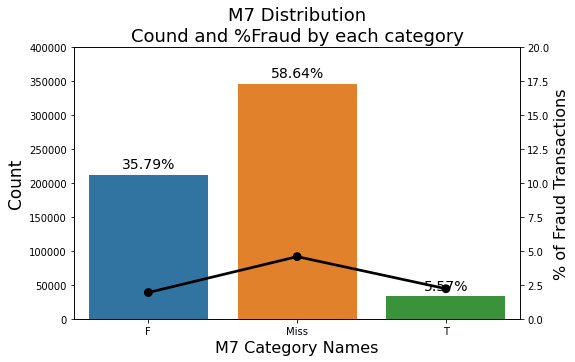

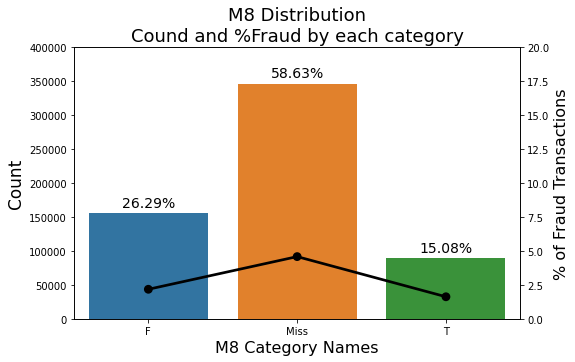

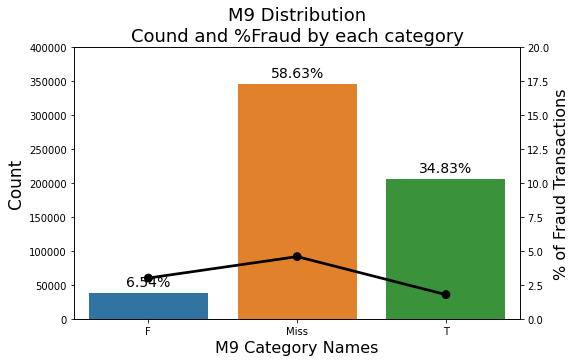

In [0]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    plotting_dist(df_tran, col)

Note: The percentage in writing is for the bar graph and the black line plot has its yaxis on the right hand side

My understanding from this data is that the majority of the percentage of fraud transactions have taken place in the missing cateogory. Also the total number of values are at the missing values. By missing category these values had Nan, I replaced it with missing

#Address 1 and Address2
Let us take a look at the address data and see what pops up

In [0]:
df_tran['addr1'].describe()
## Here we can see that that the distribution is a range between 101 and 540

count    524834.000000
mean        290.733794
std         101.741072
min         100.000000
25%         204.000000
50%         299.000000
75%         330.000000
max         540.000000
Name: addr1, dtype: float64

(0.0, 598553.1499999999)

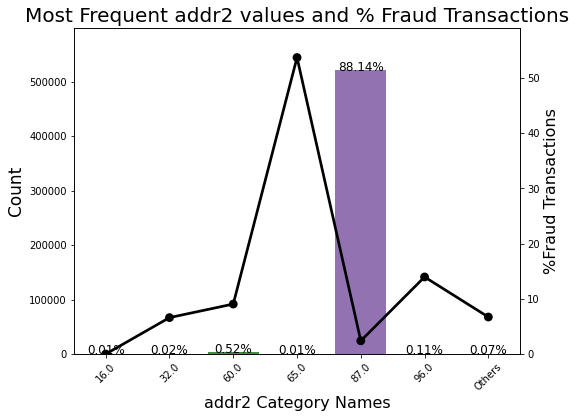

In [0]:
df_tran.loc[df_tran.addr2.isin(df_tran.addr2.value_counts()[df_tran.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

tmp = pd.crosstab(df_tran['addr2'], df_tran['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
total = len(df_tran['addr2'])
    
plt.figure(figsize=(8,6))    
g = sns.countplot( x='addr2',  data=df_tran, order=list(tmp['addr2'].values))
gt = g.twinx()
gt = sns.pointplot(x='addr2', y='Fraud', data=tmp, order=list(tmp['addr2'].values),
                       color='black', legend=False )
gt.set_ylim(0,tmp['Fraud'].max()*1.1)
gt.set_ylabel("%Fraud Transactions", fontsize=16)
g.set_title(f"Most Frequent {'addr2'} values and % Fraud Transactions", fontsize=20)
g.set_xlabel(f"{'addr2'} Category Names", fontsize=16)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
  height = p.get_height()
  sizes.append(height)
  g.text(p.get_x()+p.get_width()/2.,
       height + 3,
       '{:1.2f}%'.format(height/total*100),
       ha="center",fontsize=12) 
        
g.set_ylim(0,max(sizes)*1.15)
 

There for what we can learn from this is that though the majority of the values for addr2(88.14%) at a single value and that value has suprisingly a very low amount of Fraud(<7%). I am nots sure what to make out of it

#Purchaser Email Domain

We can take a look at the email domain of the purchaser and look for any possible trends in it. We might wanna look at the n

In [0]:
df_tran.loc[df_tran['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_tran.loc[df_tran['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_tran.loc[df_tran.P_emaildomain.isin(df_tran.P_emaildomain\
                                         .value_counts()[df_tran.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_tran.P_emaildomain.fillna("NoInf", inplace=True)

(0.0, 262608.25)

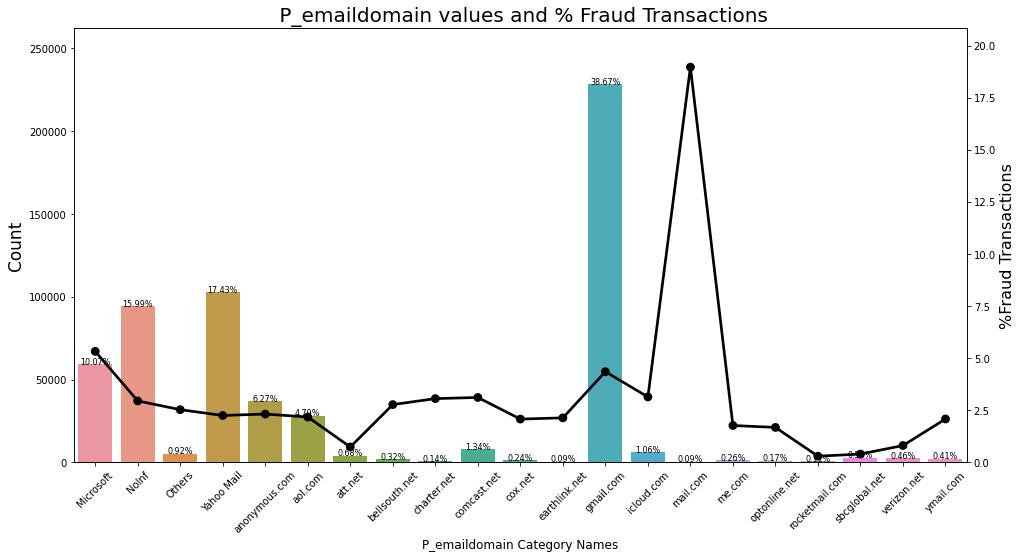

In [0]:
tmp = pd.crosstab(df_tran['P_emaildomain'], df_tran['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
total = len(df_tran['addr2'])
    
plt.figure(figsize=(16,8))    
g = sns.countplot( x='P_emaildomain',  data=df_tran, order=list(tmp['P_emaildomain'].values))
gt = g.twinx()
gt = sns.pointplot(x='P_emaildomain', y='Fraud', data=tmp, order=list(tmp['P_emaildomain'].values),
                       color='black', legend=False )
gt.set_ylim(0,tmp['Fraud'].max()*1.1)
gt.set_ylabel("%Fraud Transactions", fontsize=16)
g.set_title(f" {'P_emaildomain'} values and % Fraud Transactions", fontsize=20)
g.set_xlabel(f"{'P_emaildomain'} Category Names", fontsize=12)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
  height = p.get_height()
  sizes.append(height)
  g.text(p.get_x()+p.get_width()/2.,
       height + 3,
       '{:1.2f}%'.format(height/total*100),
       ha="center",fontsize=8) 
        
g.set_ylim(0,max(sizes)*1.15)

Inference from the above plots is that most of the purchase have been taken place through the gmail.com. The major % of Fraud Transactions hav taken place through Microsoft.email

# Recipeint Email Domain

In [0]:
df_tran.loc[df_tran['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_tran.loc[df_tran['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_tran.loc[df_tran['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_tran.loc[df_tran.R_emaildomain.isin(df_tran.R_emaildomain\
                                         .value_counts()[df_tran.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_tran.R_emaildomain.fillna("NoInf", inplace=True)

(0.0, 521236.35)

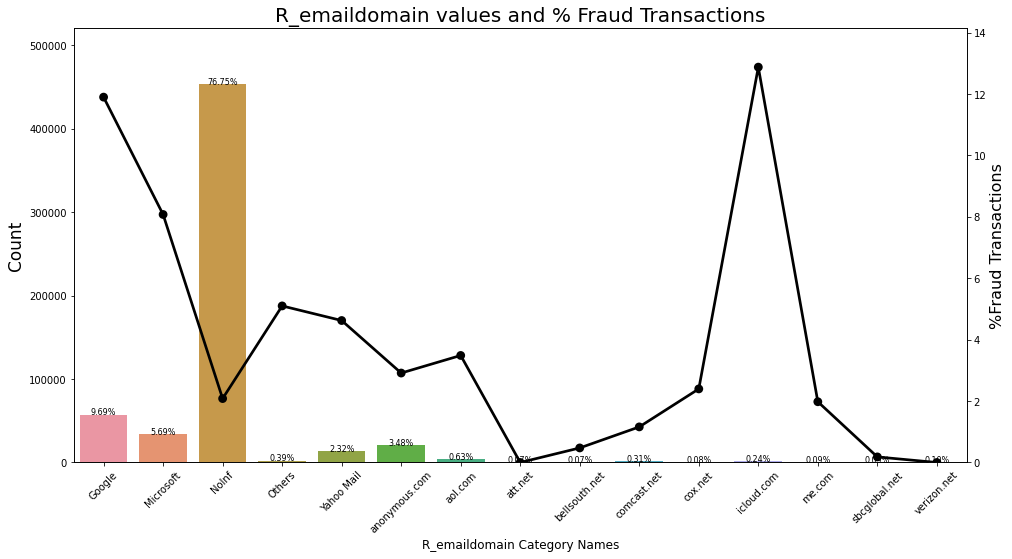

In [0]:
tmp = pd.crosstab(df_tran['R_emaildomain'], df_tran['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
total = len(df_tran['addr2'])
    
plt.figure(figsize=(16,8))    
g = sns.countplot( x='R_emaildomain',  data=df_tran, order=list(tmp['R_emaildomain'].values))
gt = g.twinx()
gt = sns.pointplot(x='R_emaildomain', y='Fraud', data=tmp, order=list(tmp['R_emaildomain'].values),
                       color='black', legend=False )
gt.set_ylim(0,tmp['Fraud'].max()*1.1)
gt.set_ylabel("%Fraud Transactions", fontsize=16)
g.set_title(f"{'R_emaildomain'} values and % Fraud Transactions", fontsize=20)
g.set_xlabel(f"{'R_emaildomain'} Category Names", fontsize=12)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
  height = p.get_height()
  sizes.append(height)
  g.text(p.get_x()+p.get_width()/2.,
       height + 3,
       '{:1.2f}%'.format(height/total*100),
       ha="center",fontsize=8) 
        
g.set_ylim(0,max(sizes)*1.15)

In the recipient email adresses the insight is that there the majority of transactions have taken place at Noinf but it has a lower percentage of fraud. 

Google has a little more than 12% of the fraud transactions but the total count of transancatons is only 9.89%

There definitely is a lot of data cleaning that has to be done in this dataset. 

#Time Delta Feature

In [0]:
import math
import datetime
start_date = '2017-12-01'
startdate = datetime.datetime.strptime(start_date,'%Y-%m-%d')
df_tran['TransactionDT'] = df_tran['TransactionDT'].apply(lambda x: startdate + datetime.timedelta(seconds = x))
print(df_tran['TransactionDT'].head())

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]


In [0]:
df_tran['TransactionDT'].tail()

590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: TransactionDT, dtype: datetime64[ns]

In [0]:
(max(df_tran['TransactionDT']) - min(df_tran['TransactionDT'])).days

181

The training data is spread over a course of 6  months starting from the 2017-12-01 and ending on 2018-06-01 approximately 180 days

In [0]:
## This is the total number of duration that the transactions had been taken place.  We can see that this is during the course of 180 days. It is a delta time
print((max(df_tran['TransactionDT']) - min(df_tran['TransactionDT']))/(3600*24)

0 days 00:03:01.999201


In [0]:
df_tran['TransactionDT'].tail()

590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: TransactionDT, dtype: datetime64[ns]

In [0]:
df_tran['_Weekdays'] = df_tran['TransactionDT'].dt.dayofweek
df_tran['_Hours'] = df_tran['TransactionDT'].dt.hour
df_tran['_Days'] = df_tran['TransactionDT'].dt.day

In [0]:
def ploting_cnt_amt(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    total = len(df[col])

    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)

    ###################################
    total_amt = sum(df_tran['TransactionAmt'])
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)  

    for p in g1.patches:
      height = p.get_height()
      g1.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height/total_amt*100),
               ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()



##Plot for Weekdays and the amount of Fraud Transactions

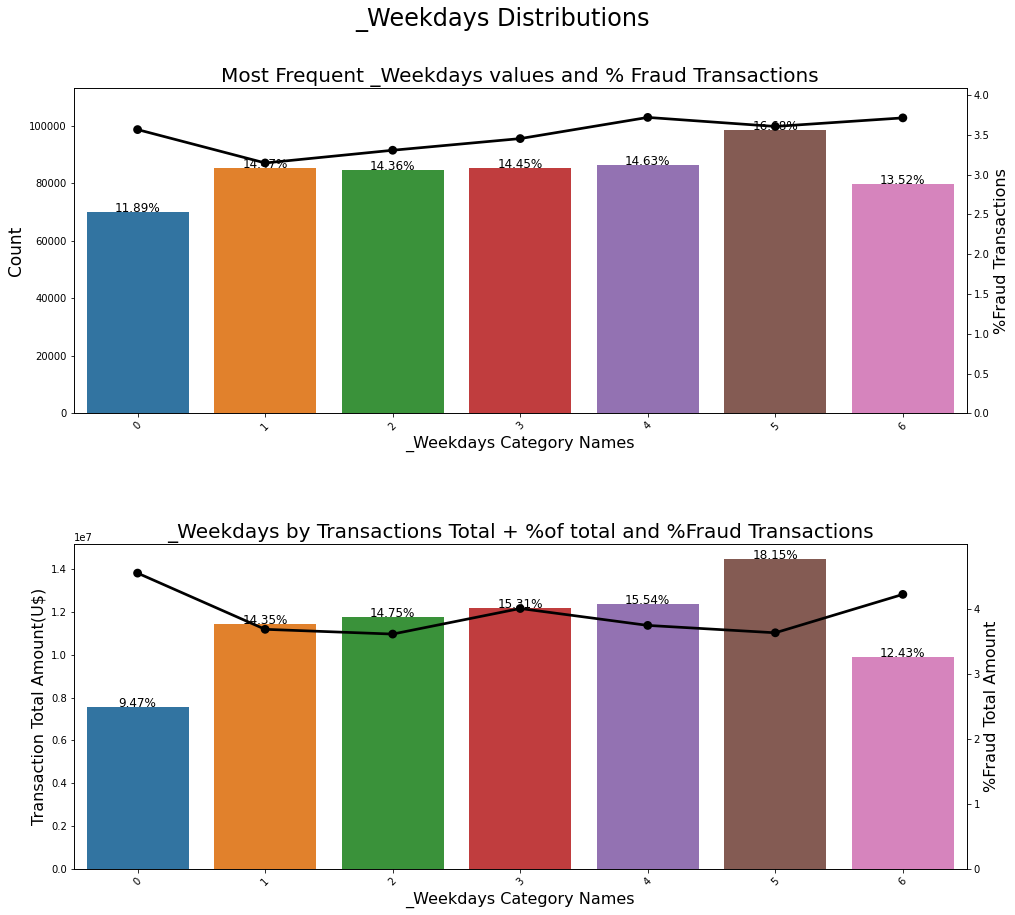

In [0]:
ploting_cnt_amt(df_tran,'_Weekdays')

Going by the weekday we can see that there is a stability in amount of transactions and the fraud. Also here zero according to the documentation stands for Monday and 6 for Sunday. I could not verify this and I am not sure

##Plot for Days and the amount of Fraud Transactions

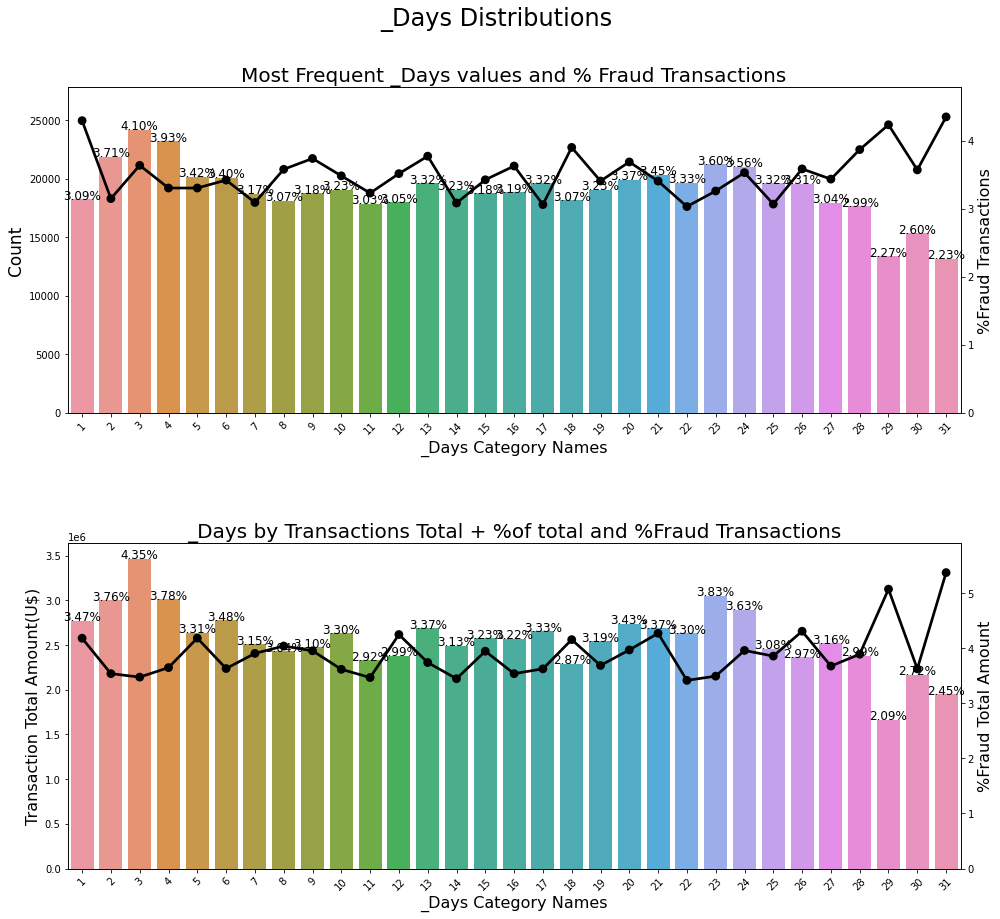

In [0]:
ploting_cnt_amt(df_tran,'_Days')

Seems like Fradulent transactions have an uptick on the end of the month. I am not sure if there is an explanation for this. 

##Plot by the Hour for  the amount of Fraud Transactions and the Count

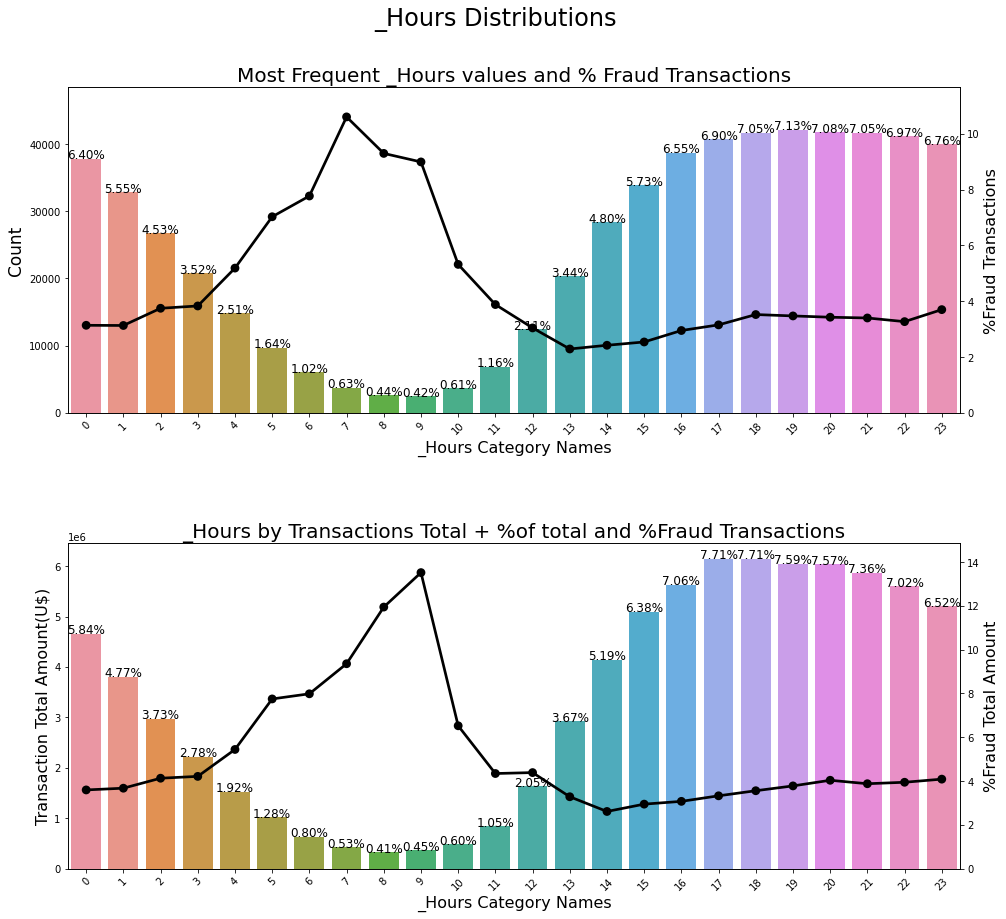

In [0]:
ploting_cnt_amt(df_tran,'_Hours')

Though there is a only few amount of transactions taking place between the 5th hour and the 10th hour(5am-10am) there seems to be a huge uptick in the amount of Fraud. Maybe if we correlate this data with that of the location of the purchase and where the transanction, that could put more insight into this.
